<a href="https://colab.research.google.com/github/Taras99/Gas_consumption_forecasting/blob/main/Mag.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)


Mounted at /content/drive


In [ ]:
import pandas as pd
from pathlib import Path
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, Embedding, LSTM, GlobalMaxPooling1D, SpatialDropout1D
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.metrics import categorical_crossentropy 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt

In [ ]:
# Seed RNG to ensure experiments are consistent
np.random.seed(42)

In [ ]:
gas_file = Path("/content/drive/MyDrive/2006-2019(+day_of_week)_t_gaz_sum_hours_full.csv")
wether_file = Path("/content/drive/MyDrive/2006-2019(3hour)_meteo_rp5ua.csv")

# Новий розділ

In [ ]:
gas_df = pd.read_csv(gas_file)
gas_df.head()

,TS,Q,DAYOFWEEK(TS)
0,2006-01-01 00:00:00,40518.2,1
1,2006-01-01 01:00:00,39043.2,1
2,2006-01-01 02:00:00,38551.7,1
3,2006-01-01 03:00:00,38284.3,1
4,2006-01-01 04:00:00,38545.7,1


In [ ]:
dataset_gas = gas_df
dataset_gas["Month"] = pd.to_datetime(gas_df["TS"]).dt.month
dataset_gas["Year"] = pd.to_datetime(gas_df["TS"]).dt.year
dataset_gas["Date"] = pd.to_datetime(gas_df["TS"]).dt.date
dataset_gas["Time"] = pd.to_datetime(gas_df["TS"]).dt.time
dataset_gas["Week"] = pd.to_datetime(gas_df["TS"]).dt.week
dataset_gas["Day"] = pd.to_datetime(gas_df["TS"]).dt.day_name()
dataset_gas = gas_df.set_index("TS")
dataset_gas.index = pd.to_datetime(dataset_gas.index)
dataset_gas.head(1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  


,Q,DAYOFWEEK(TS),Month,Year,Date,Time,Week,Day
TS,,,,,,,,
2006-01-01,40518.2,1,1,2006,2006-01-01,00:00:00,52,Sunday


In [ ]:
# How many Unique Year do we Have in Dataset 
print(gas_df.Year.unique(),"\n")
print("Total Number of Unique Year", gas_df.Year.nunique(), "\n")

[2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019] 

Total Number of Unique Year 14 



No handles with labels found to put in legend.


Text(0.5, 1.0, 'Energy Consumption According to Year')

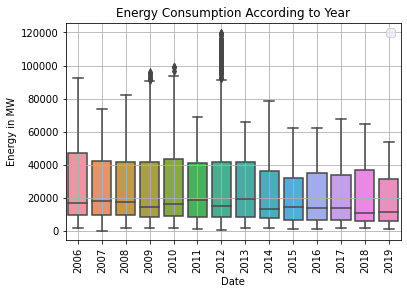

In [ ]:
#Lets us see the energy consumption Each Year
from matplotlib import style
fig = plt.figure()
ax1 = plt.subplot2grid((1,1), (0,0))

style.use('ggplot')

sns.boxplot(x=dataset_gas["Year"], y=dataset_gas["Q"], data=gas_df)
sns.set(rc={'figure.figsize':(15,6)})

plt.title("Energy consumptionnin Year ...")
plt.xlabel("Date")
plt.ylabel("Energy in MW")
plt.grid(True)
plt.legend()

for label in ax1.xaxis.get_ticklabels():
    label.set_rotation(90)


plt.title("Energy Consumption According to Year")

No handles with labels found to put in legend.


Text(0.5, 1.0, 'Energy Consumption According to Year')

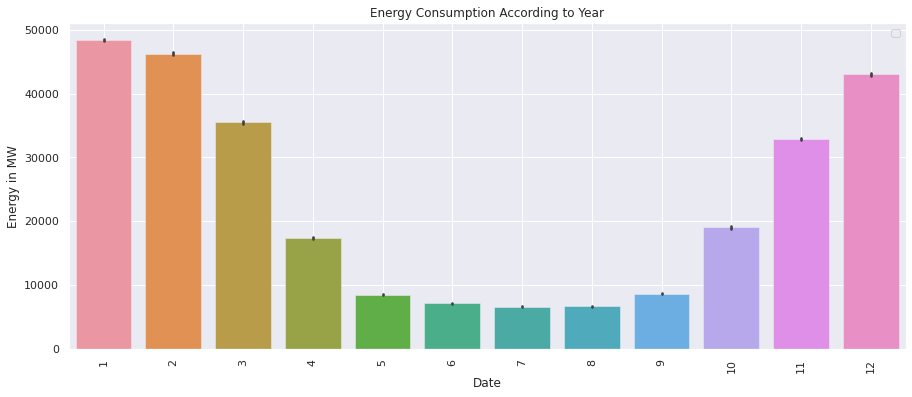

In [ ]:
#Lets us see the energy consumption Each Year
from matplotlib import style
fig = plt.figure()
ax1 = plt.subplot2grid((1,1), (0,0))

style.use('ggplot')

sns.barplot(x=dataset_gas["Month"], y=dataset_gas["Q"], data=gas_df)
sns.set(rc={'figure.figsize':(15,6)})

plt.title("Energy consumptionnin Year ...")
plt.xlabel("Date")
plt.ylabel("Energy in MW")
plt.grid(True)
plt.legend()

for label in ax1.xaxis.get_ticklabels():
    label.set_rotation(90)


plt.title("Energy Consumption According to Year")

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Ennergy Distribution')

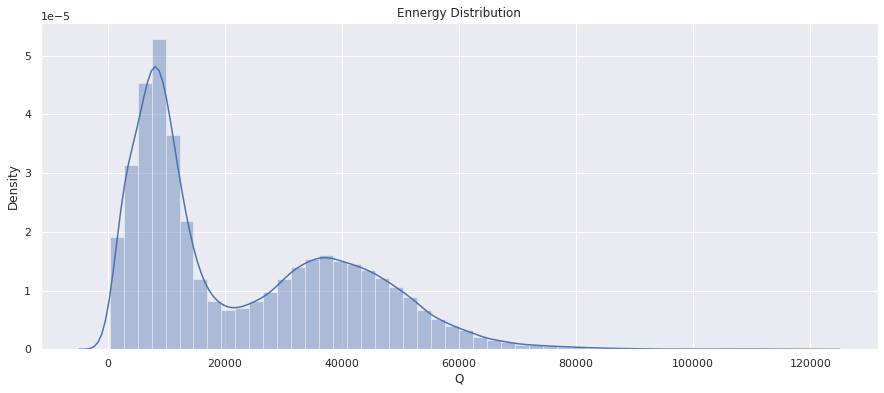

In [ ]:
sns.distplot(dataset_gas["Q"])
plt.title("Ennergy Distribution")

#Prepering data for LSTM model

In [ ]:
# Resampeling 
#print(dataset_gas)

In [ ]:
NewDataSet = dataset_gas.resample('H').mean()
print(NewDataSet)

                           Q  DAYOFWEEK(TS)  Month    Year  Week
TS                                                              
2006-01-01 00:00:00  40518.2            1.0    1.0  2006.0  52.0
2006-01-01 01:00:00  39043.2            1.0    1.0  2006.0  52.0
2006-01-01 02:00:00  38551.7            1.0    1.0  2006.0  52.0
2006-01-01 03:00:00  38284.3            1.0    1.0  2006.0  52.0
2006-01-01 04:00:00  38545.7            1.0    1.0  2006.0  52.0
...                      ...            ...    ...     ...   ...
2019-12-31 19:00:00  43434.8            3.0   12.0  2019.0   1.0
2019-12-31 20:00:00  41943.0            3.0   12.0  2019.0   1.0
2019-12-31 21:00:00  39574.2            3.0   12.0  2019.0   1.0
2019-12-31 22:00:00  36841.5            3.0   12.0  2019.0   1.0
2019-12-31 23:00:00  33227.7            3.0   12.0  2019.0   1.0

[122712 rows x 5 columns]


In [ ]:
print("Old Dataset ",dataset_gas.shape )
print("New  Dataset ",NewDataSet.shape )

Old Dataset  (122712, 8)
New  Dataset  (122712, 5)


In [ ]:
TestData = NewDataSet.tail(100)

Training_Set = NewDataSet.iloc[:,0:1]

Training_Set = Training_Set[:-60]

In [ ]:
print("Training Set Shape ", Training_Set.shape)
print("Test Set Shape ", TestData.shape)

Training Set Shape  (122652, 1)
Test Set Shape  (100, 5)


In [ ]:
Training_Set = Training_Set.values
sc = MinMaxScaler(feature_range=(0, 1))
Train = sc.fit_transform(Training_Set)

In [ ]:
X_Train = []
Y_Train = []

# Range should be fromm 60 Values to END 
for i in range(60, Train.shape[0]):
    
    # X_Train 0-59 
    X_Train.append(Train[i-60:i])
    
    # Y Would be 60 th Value based on past 60 Values 
    Y_Train.append(Train[i])

# Convert into Numpy Array
X_Train = np.array(X_Train)
Y_Train = np.array(Y_Train)

print(X_Train.shape)
print(Y_Train.shape)

(122592, 60, 1)
(122592, 1)


In [ ]:
# Shape should be Number of [Datapoints , Steps , 1 )
# we convert into 3-d Vector or #rd Dimesnsion
X_Train = np.reshape(X_Train, newshape=(X_Train.shape[0], X_Train.shape[1], 1))
X_Train.shape

(122592, 60, 1)

In [ ]:
#MODEL

regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_Train.shape[1], 1)))
regressor.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [ ]:
regressor.fit(X_Train, Y_Train, epochs = 50, batch_size = 32)

Epoch 1/50
3831/3831 [==============================] - 335s 87ms/step - loss: 4.1056e-04
Epoch 2/50
3831/3831 [==============================] - 336s 88ms/step - loss: 4.1092e-04
Epoch 3/50
3831/3831 [==============================] - 336s 88ms/step - loss: 4.0671e-04
Epoch 4/50
3831/3831 [==============================] - 336s 88ms/step - loss: 4.0209e-04
Epoch 5/50
3831/3831 [==============================] - 335s 88ms/step - loss: 3.9708e-04
Epoch 6/50
3831/3831 [==============================] - 333s 87ms/step - loss: 3.9273e-04
Epoch 7/50
3831/3831 [==============================] - 335s 87ms/step - loss: 3.8960e-04
Epoch 8/50
3831/3831 [==============================] - 335s 87ms/step - loss: 3.8864e-04
Epoch 9/50
3831/3831 [==============================] - 336s 88ms/step - loss: 3.7928e-04
Epoch 10/50
3831/3831 [==============================] - 337s 88ms/step - loss: 3.8399e-04
Epoch 11/50
3831/3831 [==============================] - 328s 86ms/step - loss: 3.7758e-04
Epoch 12

In [ ]:
TestData.head(2)

,Q,DAYOFWEEK(TS),Month,Year,Week
TS,,,,,
2019-12-27 20:00:00,38842.4,6.0,12.0,2019.0,52.0
2019-12-27 21:00:00,38225.3,6.0,12.0,2019.0,52.0


In [ ]:
TestData.shape

(100, 5)

In [ ]:
NewDataSet.shape

(122712, 5)

In [ ]:
Df_Total = NewDataSet[["Q"]]

In [ ]:
Df_Total.shape

(122712, 1)

In [ ]:
inputs = Df_Total[len(Df_Total) - len(TestData) - 60:].values
inputs.shape

(160, 1)

In [ ]:
inputs = Df_Total[len(Df_Total) - len(TestData) - 60:].values

# We need to Reshape
inputs = inputs.reshape(-1,1)

# Normalize the Dataset
inputs = sc.transform(inputs)

X_test = []
for i in range(60, 160):
    X_test.append(inputs[i-60:i])
    
# Convert into Numpy Array
X_test = np.array(X_test)

# Reshape before Passing to Network
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Pass to Model 
predicted_Q = regressor.predict(X_test)

# Do inverse Transformation to get Values 
predicted_Q = sc.inverse_transform(predicted_Q)

In [ ]:
True_M3 = TestData["Q"].to_list()
Predicted_M3  = predicted_Q
dates = TestData.index.to_list()

In [ ]:
Machine_Df = pd.DataFrame(data={
    "Date":dates,
    "TrueM3": True_M3,
    "PredictedM3":[x[0] for x in Predicted_M3 ]
})

In [ ]:
#Future Predicted
Machine_Df

,Date,TrueM3,PredictedM3
0,2019-12-27 20:00:00,38842.4,38259.347656
1,2019-12-27 21:00:00,38225.3,37046.214844
2,2019-12-27 22:00:00,36877.4,34316.808594
3,2019-12-27 23:00:00,32856.5,30565.976562
4,2019-12-28 00:00:00,30854.9,29490.365234
...,...,...,...
95,2019-12-31 19:00:00,43434.8,43133.640625
96,2019-12-31 20:00:00,41943.0,42687.921875
97,2019-12-31 21:00:00,39574.2,40895.941406
98,2019-12-31 22:00:00,36841.5,37004.902344


In [ ]:
True_M3 = TestData["Q"].to_list()
Predicted_M3  = [x[0] for x in Predicted_M3]
dates = TestData.index.to_list()

IndexError: ignored

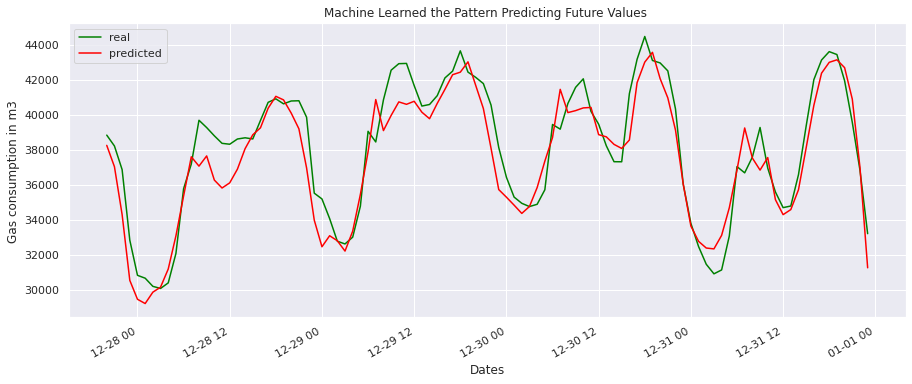

In [ ]:
fig = plt.figure()

ax1= fig.add_subplot(111)

x = dates
y = True_M3

y1 = Predicted_M3

plt.plot(x,y, color="green",label = 'real')
plt.plot(x,y1, color="red",label = 'predicted')
# beautify the x-labels
plt.gcf().autofmt_xdate()
plt.xlabel('Dates')
plt.ylabel("Gas consumption in m3 ")
plt.title("Machine Learned the Pattern Predicting Future Values ")
plt.legend()

In [ ]:
# cleanup gas data by converting TS column to timestamp
gas_df = pd.read_csv(gas_file).assign(TS=lambda df: pd.to_datetime(df.TS))

In [ ]:
# cleanup the weather data by removing empty columns and converting time to datetime objects
weather_df = pd.read_csv(wether_file) \
    .assign(Time=lambda df: pd.to_datetime(df.Time)) \
    .drop(columns=['DD', 'N', 'WW', 'W1', 'W2', 'Cl', 'Nh', 'H', 'Cm', 'Ch', 'E', 'E1'])

In [ ]:
weather_df.head(10)

,id,Time,T,Po,P,Pa,U,Ff,ff10,ff3,Tn,Tx,VV,Td,RRR,tR,Tg,sss
0,2626,2006-01-01 02:00:00,-2.8,732.7,763.5,0.3,82.0,3.0,19.0,18.0,-4.550,0.6250,10.0,-5.5,1.760000,10.00000,-2.0,1.0
1,2627,2006-01-01 05:00:00,-4.5,733.3,764.4,0.3,86.0,2.0,19.0,18.0,-4.775,0.7375,10.0,-6.5,1.720000,9.66667,-2.0,1.0
2,2628,2006-01-01 08:00:00,-4.1,733.3,764.4,0.3,89.0,3.0,19.0,18.0,-5.000,0.8500,10.0,-5.7,1.680000,9.33333,-2.0,1.0
3,2629,2006-01-01 11:00:00,-1.8,734.4,765.3,0.3,79.0,3.0,19.0,18.0,-4.650,0.9625,10.0,-4.9,1.640000,9.00000,-2.0,1.0
4,2630,2006-01-01 14:00:00,1.2,733.4,763.9,0.3,74.0,3.0,19.0,18.0,-4.300,1.0750,10.0,-3.0,1.600000,8.66667,-2.0,1.0
5,2631,2006-01-01 17:00:00,1.0,733.6,764.0,0.3,75.0,6.0,19.0,18.0,-3.950,1.1875,10.0,-2.9,1.560000,8.33333,-2.0,1.0
6,2632,2006-01-01 20:00:00,-0.6,733.6,764.2,0.3,78.0,5.0,19.0,18.0,-3.600,1.3000,10.0,-4.0,1.520000,8.00000,-2.0,1.0
7,2633,2006-01-01 23:00:00,-1.9,733.8,764.6,0.3,81.0,5.0,19.0,18.0,-3.250,1.5500,10.0,-4.7,1.480000,7.66667,-2.0,1.0
8,2874,2006-01-02 02:00:00,-1.6,733.0,763.9,0.3,94.0,5.0,19.0,18.0,-3.050,-1.6500,4.0,-2.4,0.483333,6.00000,-2.0,3.0
9,2875,2006-01-02 05:00:00,-1.2,732.5,763.3,0.3,93.0,8.0,19.0,18.0,-2.825,-1.2750,4.0,-2.2,0.475000,9.00000,-2.0,3.0


In [ ]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41052 entries, 0 to 41051
Data columns (total 18 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   id      41052 non-null  int64         
 1   Time    41052 non-null  datetime64[ns]
 2   T       41052 non-null  float64       
 3   Po      41052 non-null  float64       
 4   P       41052 non-null  float64       
 5   Pa      41052 non-null  float64       
 6   U       41052 non-null  float64       
 7   Ff      41052 non-null  float64       
 8   ff10    41052 non-null  float64       
 9   ff3     41052 non-null  float64       
 10  Tn      41052 non-null  float64       
 11  Tx      41052 non-null  float64       
 12  VV      41052 non-null  float64       
 13  Td      41052 non-null  float64       
 14  RRR     41052 non-null  float64       
 15  tR      41052 non-null  float64       
 16  Tg      41052 non-null  float64       
 17  sss     41052 non-null  float64       
dtypes: dat

In [ ]:
gas_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122712 entries, 0 to 122711
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   TS             122712 non-null  datetime64[ns]
 1   Q              122712 non-null  float64       
 2   DAYOFWEEK(TS)  122712 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 2.8 MB


In [ ]:
gas_df.rename(columns = {'TS':'Time'}, inplace = True)

In [ ]:
gas_df.head()

,Time,Q,DAYOFWEEK(TS)
0,2006-01-01 00:00:00,40518.2,1
1,2006-01-01 01:00:00,39043.2,1
2,2006-01-01 02:00:00,38551.7,1
3,2006-01-01 03:00:00,38284.3,1
4,2006-01-01 04:00:00,38545.7,1


In [ ]:
n = gas_df['Time']

In [ ]:
# simple merge of the dataframes 
df = pd.merge(gas_df,weather_df, on="Time", how="outer")

In [ ]:
df = df.drop('Time', axis = 1)

KeyError: ignored

In [ ]:
df = df.interpolate(method ='linear', limit_direction ='backward', axis = 0)

In [ ]:
df['Time'] = n

In [ ]:
df = pd.merge(n,df, on="Time", how="inner")

In [ ]:
df = df.dropna()

In [ ]:
9# convert time to seconds since epoch and fill missing values with zeroes
# TODO: check number of missing values beforehand
# TODO: use better strategy to fill missing values
data = df.assign(timestamp=lambda df: df.Time.apply(lambda t: t.timestamp())).fillna(0).drop(columns=["Time"])

In [ ]:

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 122712 entries, 0 to 122711
Data columns (total 20 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Q              122712 non-null  float64
 1   DAYOFWEEK(TS)  122712 non-null  float64
 2   id             122712 non-null  float64
 3   T              122712 non-null  float64
 4   Po             122712 non-null  float64
 5   P              122712 non-null  float64
 6   Pa             122712 non-null  float64
 7   U              122712 non-null  float64
 8   Ff             122712 non-null  float64
 9   ff10           122712 non-null  float64
 10  ff3            122712 non-null  float64
 11  Tn             122712 non-null  float64
 12  Tx             122712 non-null  float64
 13  VV             122712 non-null  float64
 14  Td             122712 non-null  float64
 15  RRR            122712 non-null  float64
 16  tR             122712 non-null  float64
 17  Tg             122712 non-nul

In [ ]:
data.tail()

,Q,DAYOFWEEK(TS),id,T,Po,P,Pa,U,Ff,ff10,ff3,Tn,Tx,VV,Td,RRR,tR,Tg,sss,timestamp
122707,28844.6,4.0,43567.333333,2.166667,733.700000,764.000000,0.033333,93.0,3.000000,18.0,22.297633,1.700000,11.858333,10.0,1.166667,1.0,12.0,-3.0,2.0,1.577819e+09
122708,29502.1,4.0,43567.666667,2.233333,733.800000,764.100000,0.166667,93.0,2.000000,18.0,22.302867,1.750000,11.804167,10.0,1.233333,1.0,12.0,-3.0,2.0,1.577822e+09
122709,30441.7,4.0,43568.000000,2.300000,733.900000,764.200000,0.300000,93.0,1.000000,18.0,22.308100,1.800000,11.750000,10.0,1.300000,1.0,12.0,-3.0,2.0,1.577826e+09
122710,28379.4,4.0,43568.333333,3.466667,734.166667,764.333333,0.466667,92.0,0.666667,18.0,22.313333,1.733333,11.695833,10.0,2.266667,1.0,12.0,-3.0,2.0,1.577830e+09
122711,21092.4,4.0,43568.666667,4.633333,734.433333,764.466667,0.633333,91.0,0.333333,18.0,22.318567,1.666667,11.641667,10.0,3.233333,1.0,12.0,-3.0,2.0,1.577833e+09


In [ ]:
data = data.drop(columns = ['timestamp','DAYOFWEEK(TS)','id'])

In [ ]:
# output basic information about gas consumption dataset 
print("="*50)
print("First Five Rows ","\n")
print(gas_df.head(2),"\n")

print("="*50)
print("Information About Dataset","\n")
print(gas_df.info(),"\n")

print("="*50)
print("Describe the Dataset ","\n")
print(gas_df.describe(),"\n")

print("="*50)
print("Null Values t ","\n")
print(gas_df.isnull().sum(),"\n")

First Five Rows  

                 Time        Q  DAYOFWEEK(TS)
0 2006-01-01 00:00:00  40518.2              1
1 2006-01-01 01:00:00  39043.2              1 

Information About Dataset 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122712 entries, 0 to 122711
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Time           122712 non-null  datetime64[ns]
 1   Q              122712 non-null  float64       
 2   DAYOFWEEK(TS)  122712 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 2.8 MB
None 

Describe the Dataset  

                   Q  DAYOFWEEK(TS)
count  122712.000000  122712.000000
mean    23260.283053       3.998827
std     18292.398895       2.000106
min       319.134000       1.000000
25%      7868.097500       2.000000
50%     15041.100000       4.000000
75%     38186.100000       6.000000
max    119741.500000       7.000000 

Null Values t  



In [ ]:
data.corr()

,Q,T,Po,P,Pa,U,Ff,ff10,ff3,Tn,Tx,VV,Td,RRR,tR,Tg,sss
Q,1.000000,-0.503515,0.056579,0.148122,0.054813,0.175393,0.086563,0.019948,-0.078041,-0.533895,-0.548180,-0.214740,-0.512627,-0.191110,-0.044270,-0.293040,0.289896
T,-0.503515,1.000000,-0.136535,-0.312794,-0.062711,-0.544849,-0.005701,-0.029918,0.112185,0.924919,0.940239,0.380915,0.914272,0.343770,0.078780,0.403669,-0.439649
Po,0.056579,-0.136535,1.000000,0.982959,0.036733,-0.079571,-0.192216,0.038397,0.022541,-0.185533,-0.099854,0.026942,-0.196962,-0.123721,0.111496,-0.019973,-0.002068
P,0.148122,-0.312794,0.982959,1.000000,0.046284,0.017689,-0.182262,0.041249,0.000351,-0.348450,-0.267753,-0.042398,-0.357860,-0.181619,0.092433,-0.096157,0.080905
Pa,0.054813,-0.062711,0.036733,0.046284,1.000000,0.128168,0.028988,-0.047040,-0.022018,0.001142,-0.029755,-0.093175,-0.001333,0.014815,0.010334,-0.162470,-0.006603
U,0.175393,-0.544849,-0.079571,0.017689,0.128168,1.000000,-0.186847,-0.023345,-0.080118,-0.266577,-0.420065,-0.565440,-0.166642,-0.052670,-0.103712,-0.166385,0.169710
Ff,0.086563,-0.005701,-0.192216,-0.182262,0.028988,-0.186847,1.000000,0.038452,0.014853,-0.044677,-0.155042,0.104060,-0.091979,-0.054299,-0.099336,-0.049129,0.005741
ff10,0.019948,-0.029918,0.038397,0.041249,-0.047040,-0.023345,0.038452,1.000000,0.124649,-0.027365,-0.033359,0.003097,-0.044685,-0.004084,-0.008395,0.003096,0.001841
ff3,-0.078041,0.112185,0.022541,0.000351,-0.022018,-0.080118,0.014853,0.124649,1.000000,0.107702,0.120818,0.060423,0.094410,0.063019,0.016836,0.131477,-0.109429
Tn,-0.533895,0.924919,-0.185533,-0.348450,0.001142,-0.266577,-0.044677,-0.027365,0.107702,1.000000,0.928736,0.271392,0.964646,0.370497,0.058718,0.414356,-0.478212


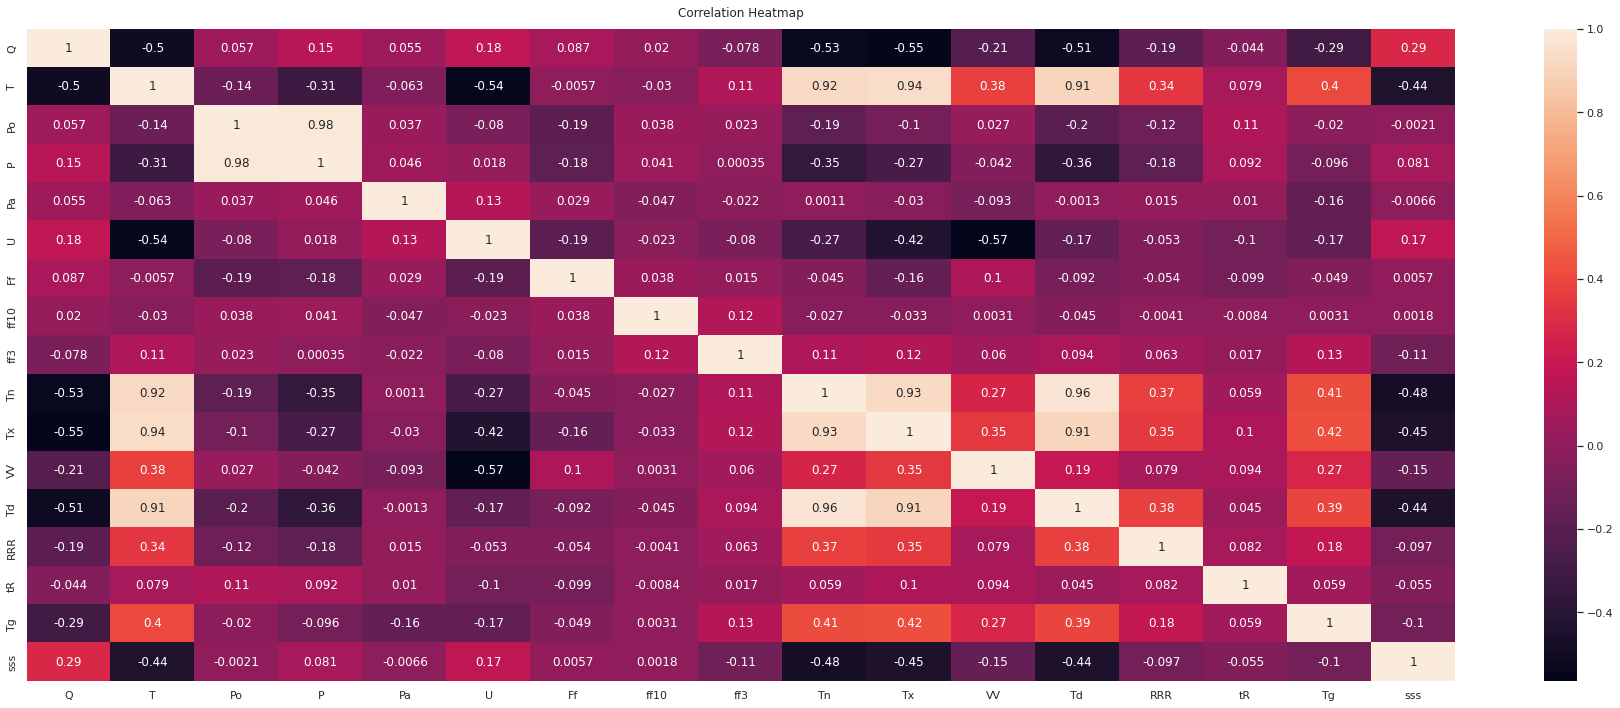

In [ ]:
# Increase the size of the heatmap.
plt.figure(figsize=(32, 12))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(data.corr(), annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

In [ ]:
data = data.drop(columns=['Po','Tx','Tn','Tg','ff3','ff10','Td','Pa'])

KeyError: ignored

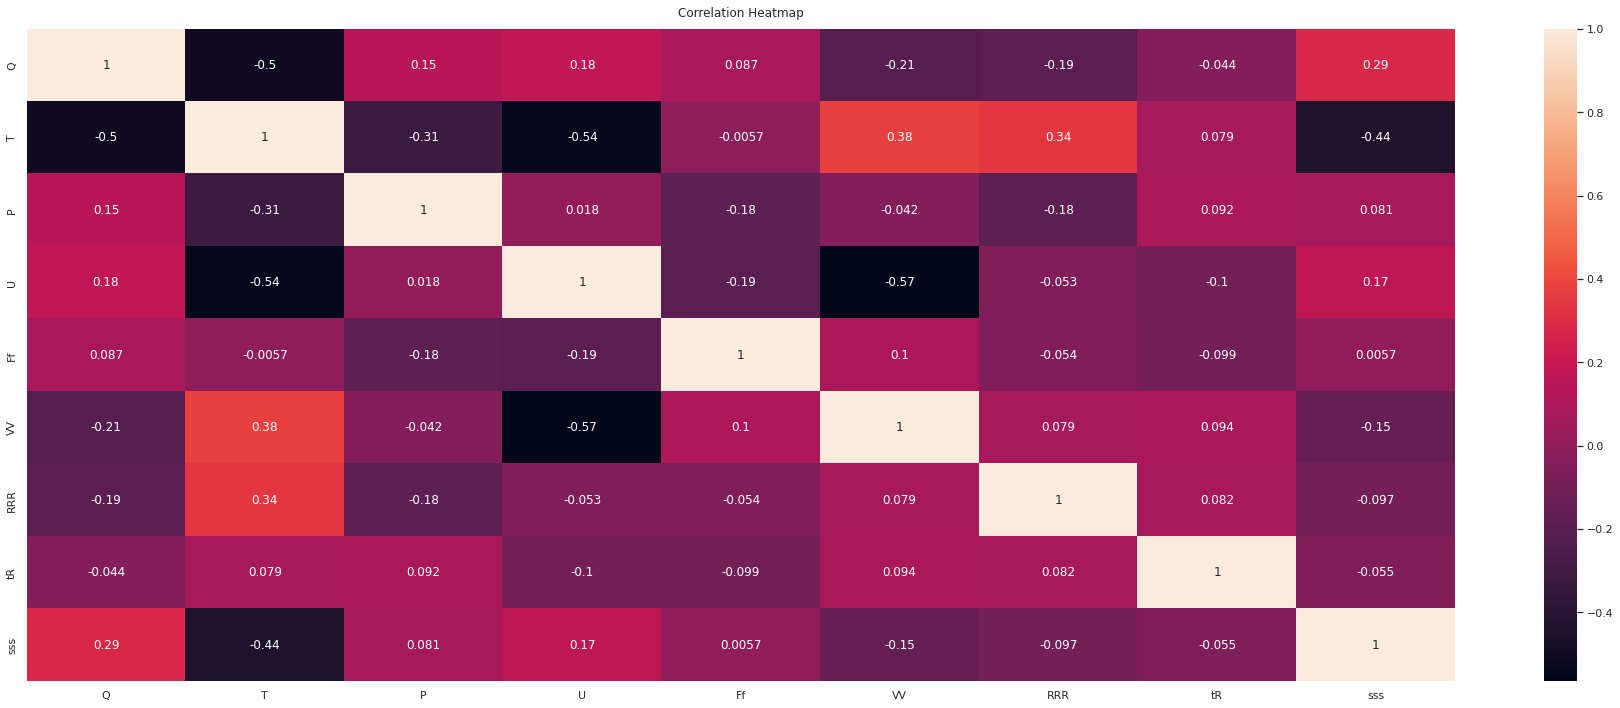

In [ ]:
# Increase the size of the heatmap.
plt.figure(figsize=(32, 12))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(data.corr(), annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

#Preparing data for SLP and MLP

In [ ]:
df = df.drop(columns=['DAYOFWEEK(TS)','Po','Tx','Tn','Tg','ff3','ff10','Td','Pa','id','Time'])

In [ ]:

#print (df)
df.info()        

<class 'pandas.core.frame.DataFrame'>
Int64Index: 122712 entries, 0 to 122711
Data columns (total 9 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Q       122712 non-null  float64
 1   T       122712 non-null  float64
 2   P       122712 non-null  float64
 3   U       122712 non-null  float64
 4   Ff      122712 non-null  float64
 5   VV      122712 non-null  float64
 6   RRR     122712 non-null  float64
 7   tR      122712 non-null  float64
 8   sss     122712 non-null  float64
dtypes: float64(9)
memory usage: 9.4 MB


In [ ]:
from sklearn.model_selection import train_test_split


In [ ]:
X = df.iloc[:,1:]
X = X.values
y = df.iloc[:,0:1]
y = y.values

In [ ]:
scaler = MinMaxScaler()
# transform data
X = scaler.fit_transform(X)
y = scaler.fit_transform(y)



In [ ]:
train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.999, test_size=0.001)

In [ ]:
type(train_X)
train_X.shape
train_y.shape

(122589, 1)

In [ ]:
# create model
model_8 = Sequential()
model_8.add(Dense(8, input_shape=(8,),kernel_initializer='normal', activation='linear'))
model_8.add(Dense(4,   activation='linear'))
model_8.add(Dense(1, activation='linear'))
# Compile model
model_8.compile(loss='mean_absolute_error', optimizer='adam')

In [ ]:
model_8.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_28 (Dense)            (None, 8)                 72        
                                                                 
 dense_29 (Dense)            (None, 4)                 36        
                                                                 
 dense_30 (Dense)            (None, 1)                 5         
                                                                 
Total params: 113
Trainable params: 113
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_8.fit(train_X, train_y, epochs=20, batch_size=32,
          verbose=2)

#Prediction MLP

In [ ]:
predicted_y  = model_8.predict(test_X)
predicted_y = scaler.inverse_transform(predicted_y)

In [ ]:
import math

 
MSE = np.square(np.subtract(test_y, predicted_y)).mean() 
 
RMSE = math.sqrt(MSE)
print("Root Mean Square Error:\n")
print(RMSE)

In [ ]:
mean_squared_error(test_y, predicted_y)


0.03819700477603996

In [ ]:
model_2 = Sequential()
model_2.add(Dense(8, input_dim=8, activation='linear'))
model_2.add(Dense(1))
model_2.compile(loss='mean_squared_error', optimizer='adam')
model_2.summary()


Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_33 (Dense)            (None, 8)                 72        
                                                                 
 dense_34 (Dense)            (None, 1)                 9         
                                                                 
Total params: 81
Trainable params: 81
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_2.fit(train_X, train_y, epochs=20, batch_size=2, verbose=2)

Epoch 1/20


KeyboardInterrupt: ignored

#Prediction SLP

In [ ]:
predicted_y2  = model_2.predict(test_X)
predicted_y2 = scaler.inverse_transform(predicted_y2)

predicted_y = predicted_y.tolist()
predicted_y2 = predicted_y2.tolist()



AttributeError: ignored

In [ ]:
REAL = scaler.inverse_transform(test_y)

In [ ]:
Results_MLP_SLP = pd.DataFrame(data={
    "REAL":[x[0] for x in REAL ],
    "MLP": [x[0] for x in predicted_y ],
    "SLP":[x[0] for x in predicted_y2 ]
})

In [ ]:
Results_MLP_SLP.head(5)

,REAL,MLP,SLP
0,36930.80,3.152798e+09,24182.578125
1,49375.40,4.108761e+09,30127.296875
2,6962.39,1.845355e+09,17261.964844
3,18958.40,2.686685e+09,22248.732422
4,11052.30,9.243315e+08,12689.831055


In [ ]:
MSE = np.square(np.subtract(test_y, predicted_y2)).mean() 
 
RMSE = math.sqrt(MSE)
print("Root Mean Square Error:\n")
print(RMSE)

ValueError: ignored

In [ ]:
MSE = np.square(np.subtract(test_y, predicted_y)).mean() 
 
RMSE = math.sqrt(MSE)
print("Root Mean Square Error:\n")
print(RMSE)

Root Mean Square Error:

0.1423673785204798


In [ ]:
True_M3 = TestData["Q"].to_list()
#Predicted_M3  = [x[0] for x in Predicted_M3]

MSE = np.square(np.subtract(True_M3, Predicted_M3)).mean() 
 
RMSE = math.sqrt(MSE)
print("Root Mean Square Error:\n")
print(RMSE)

Root Mean Square Error:

1419.6013651381297
